In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, LSTM, Bidirectional,
    RepeatVector, TimeDistributed, Concatenate
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, Hyperband
import os

data = pd.read_csv("dataset.csv")

data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Selecionar variáveis
variables = data[['ws100', 'humid','wdisp100']].values

scaler = MinMaxScaler()
variables_scaled = scaler.fit_transform(variables)

sequence_length = 36 # janela de aprendizado de 36
num_target_steps = 6 # previsão para 6
split_ratio = 0.8 # 80% treinamento, 20% teste

split_index = int(len(variables_scaled) * split_ratio)
train_data = variables_scaled[:split_index]
test_data = variables_scaled[split_index:]

def create_sequences(data, seq_length, num_target_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - num_target_steps + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+num_target_steps, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, sequence_length, num_target_steps)
X_test, y_test = create_sequences(test_data, sequence_length, num_target_steps)

# Reshape de y_train e y_test para serem compatíveis com a saída do modelo
y_train = y_train.reshape(-1, num_target_steps, 1)
y_test = y_test.reshape(-1, num_target_steps, 1)

# Valores mínimos e máximos de 'ws100' para inversão da escala
ws100_min = scaler.data_min_[0]
ws100_max = scaler.data_max_[0]


KeyboardInterrupt: 

Definição de funções de perdas customizadas.

In [ ]:
def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def custom_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def custom_rmse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.sqrt(mse)

def custom_mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), epsilon))) * 100

def custom_weighted_mse(y_true, y_pred):
    # Definir os pesos para cada passo de previsão
    weights = tf.constant([1.0, 1.0, 1.0, 1.0, 1.0, 2.0], dtype=tf.float32)  # Peso maior para o sexto passo
    
    # Expandir dimensões para corresponder a y_true e y_pred
    weights = tf.reshape(weights, (1, -1, 1))
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

def custom_progressive_mse(y_true, y_pred):
    # Criar um vetor de pesos crescentes
    weights = tf.cast(tf.range(1, num_target_steps + 1), dtype=tf.float32)
    
    # Normalizar pesos para que a soma seja igual ao número de passos
    weights = weights / tf.reduce_mean(weights)
    
    # Expandir dimensões
    weights = tf.reshape(weights, (1, -1, 1))
    
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

def custom_focal_mse(y_true, y_pred):
    gamma = 2.0  # Parâmetro de foco
    mse = tf.square(y_true - y_pred)
    focal_mse = tf.pow(mse, gamma)
    loss = tf.reduce_mean(focal_mse)
    return loss

def custom_combined_loss(y_true, y_pred):
    # Erro quadrático médio global
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Erro absoluto médio no sexto passo
    mae_sixth = tf.reduce_mean(tf.abs(y_true[:, 5, :] - y_pred[:, 5, :]))
    
    # Combinar as perdas com pesos
    loss = mse + mae_sixth * 2  # Peso maior para o erro no sexto passo
    return loss

def custom_uncertainty_weighted_mse(y_true, y_pred):
    # Exemplo de variâncias estimadas para cada passo
    variances = tf.constant([0.5, 0.6, 0.8, 1.0, 1.2, 1.5], dtype=tf.float32)
    
    # Pesos inversamente proporcionais à variância
    weights = 1.0 / variances
    
    # Normalizar pesos
    weights = weights / tf.reduce_mean(weights)
    weights = tf.reshape(weights, (1, -1, 1))
    
    # Calcular a perda ponderada
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss


Geração do modelo usando LSTM bidirecional

In [ ]:
def build_model_bidirectional_seq2seq(hp):
    units = hp.Int('units', min_value=8, max_value=32, step=8)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = 0.3 
    num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    loss_choice = hp.Choice('loss_function', values=[
        'custom_weighted_mse',
        'custom_progressive_mse',
        'custom_focal_mse',
        'custom_combined_loss',
        'custom_uncertainty_weighted_mse'
    ])
    
    loss_functions = {
        'custom_weighted_mse': custom_weighted_mse,
        'custom_progressive_mse': custom_progressive_mse,
        'custom_focal_mse': custom_focal_mse,
        'custom_combined_loss': custom_combined_loss,
        'custom_uncertainty_weighted_mse': custom_uncertainty_weighted_mse
    }
    selected_loss = loss_functions[loss_choice]
    
    # Seleção do Otimizador com Gradient Clipping
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    
    num_features = X_train.shape[2]
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, num_features), name='encoder_inputs')
    encoder = encoder_inputs
    for i in range(num_layers):
        return_seq = True if i < num_layers - 1 else False
        return_state = True if i == num_layers - 1 else False
        encoder_lstm = Bidirectional(LSTM(
            units=units,
            return_sequences=return_seq,
            return_state=return_state,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'encoder_lstm_{i}'
        ))
        if return_state:
            # Para a última camada
            encoder_outputs = encoder_lstm(encoder)
            
            # Desempacotar os outputs
            encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_outputs
           
            # Concatenar os estados forward e backward
            state_h = Concatenate()([forward_h, backward_h])
            state_c = Concatenate()([forward_c, backward_c])
        else:
            encoder_output = encoder_lstm(encoder)
        encoder = encoder_output
        encoder = LayerNormalization(name=f'encoder_norm_{i}')(encoder)
    
    # Decoder
    decoder_inputs = RepeatVector(num_target_steps)(state_h)
    decoder = decoder_inputs
    for i in range(num_layers):
        decoder_lstm = LSTM(
            units=units * 2,  # Multiplicado por 2 devido à concatenação dos estados
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'decoder_lstm_{i}'
        )
        if i == 0:
            decoder_output = decoder_lstm(decoder, initial_state=[state_h, state_c])
        else:
            decoder_output = decoder_lstm(decoder)
        decoder = decoder_output
        decoder = LayerNormalization(name=f'decoder_norm_{i}')(decoder)
    
    # Camada de Saída
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder)
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=selected_loss,
        metrics=[
            custom_weighted_mse,
            custom_progressive_mse,
            custom_focal_mse,
            custom_combined_loss,
            custom_uncertainty_weighted_mse        
        ]
    )
    
    return model


Hypertunning do modelo para gerar os melhores parêmetros

In [ ]:
tuner = Hyperband(
    build_model_bidirectional_seq2seq,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuner_dir',
    project_name='wind_speed_prediction_bidirectional_seq2seq_robust'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Iniciar a busca de hiperparâmetros
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Obter o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Salvar o melhor modelo
model_save_path = 'best_bidirectional_seq2seq_model.h5.keras'
best_model.save(model_save_path)

Trial 5 Complete [00h 01m 49s]
val_loss: 0.010691048577427864

Best val_loss So Far: 0.0006643906235694885
Total elapsed time: 00h 30m 22s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
32                |16                |units
0.001             |0.001             |learning_rate
2                 |2                 |num_layers
rmsprop           |adam              |optimizer
custom_uncertai...|custom_focal_mse  |loss_function

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - custom_mae: 0.3789 - custom_mape: 83361.0000 - custom_rmse: 0.4631 - loss: 0.6745 - val_custom_mae: 0.1058 - val_custom_mape: 29.0915 - val_custom_rmse: 0.1225 - val_loss: 0.1857
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - custom_mae: 0.1291 - custom_mape: 99296.8516 - custom_rmse: 0.1587 - loss: 0.1514 - val_custom_mae: 0.1005 - val_custom_mape: 28.4831 - val_custom_rmse: 0.1154 - val_loss: 0.0674
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - custom_ma

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Passo 1:
MAE: 0.63
RMSE: 0.83
MAPE: 8.72%



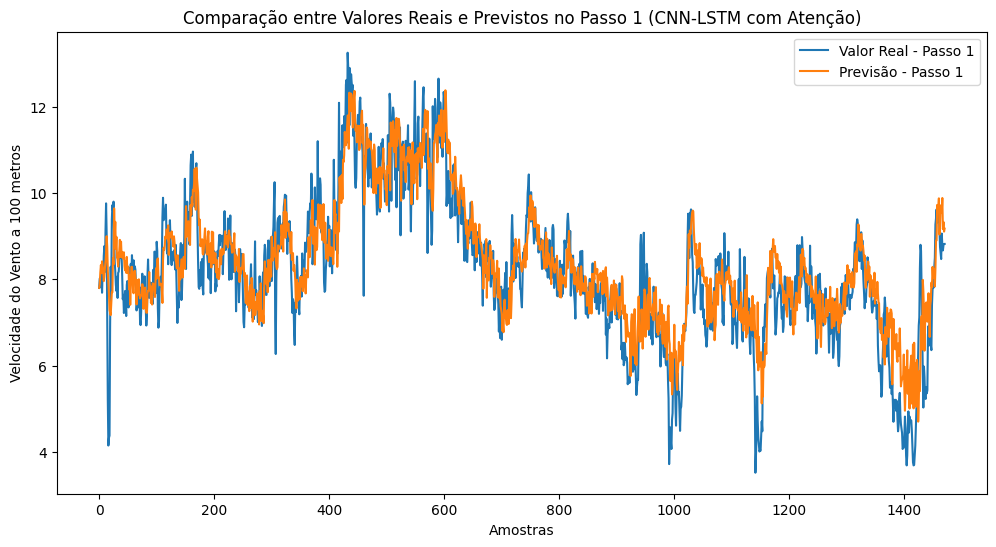

Passo 2:
MAE: 0.67
RMSE: 0.89
MAPE: 9.25%



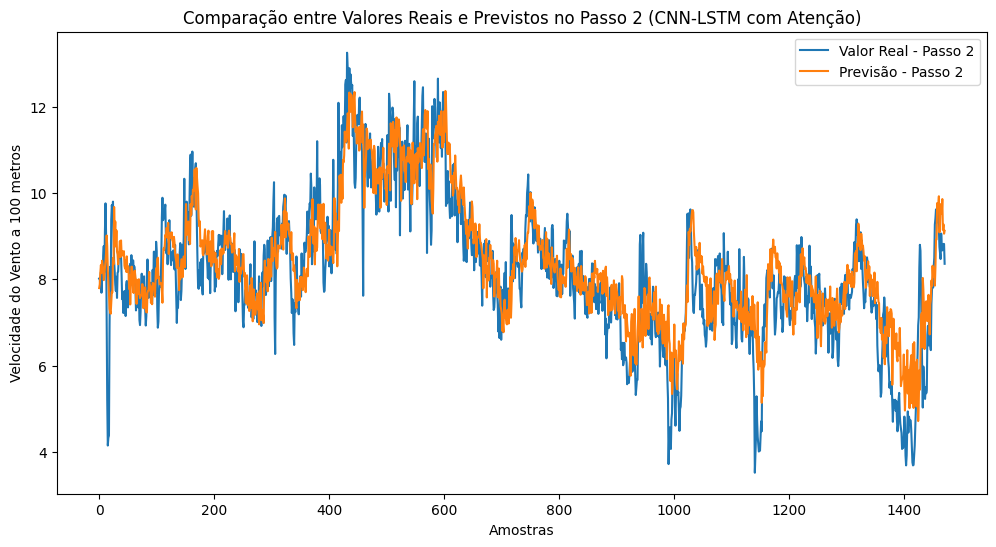

Passo 3:
MAE: 0.70
RMSE: 0.93
MAPE: 9.65%



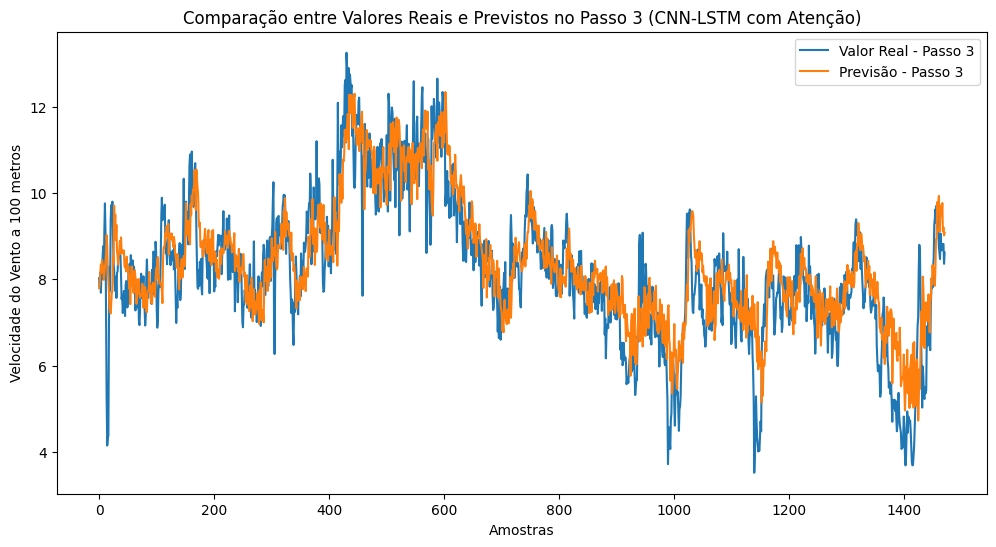

Passo 4:
MAE: 0.73
RMSE: 0.96
MAPE: 10.04%



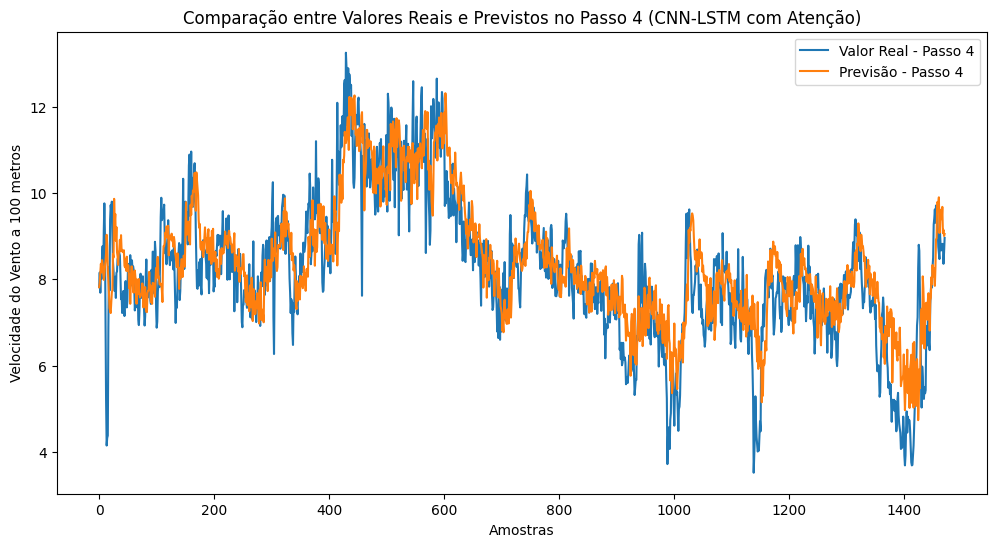

Passo 5:
MAE: 0.75
RMSE: 0.99
MAPE: 10.29%



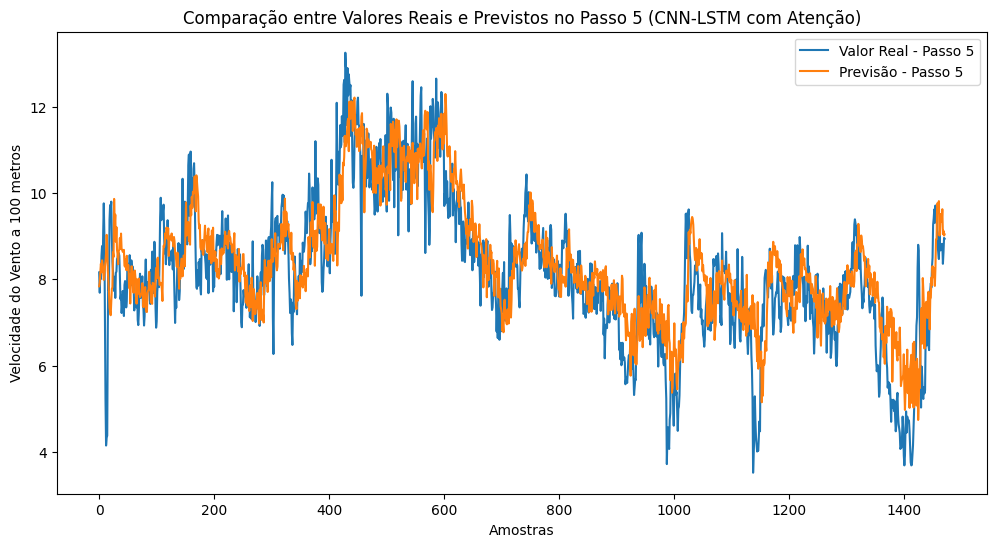

Passo 6:
MAE: 0.77
RMSE: 1.01
MAPE: 10.49%



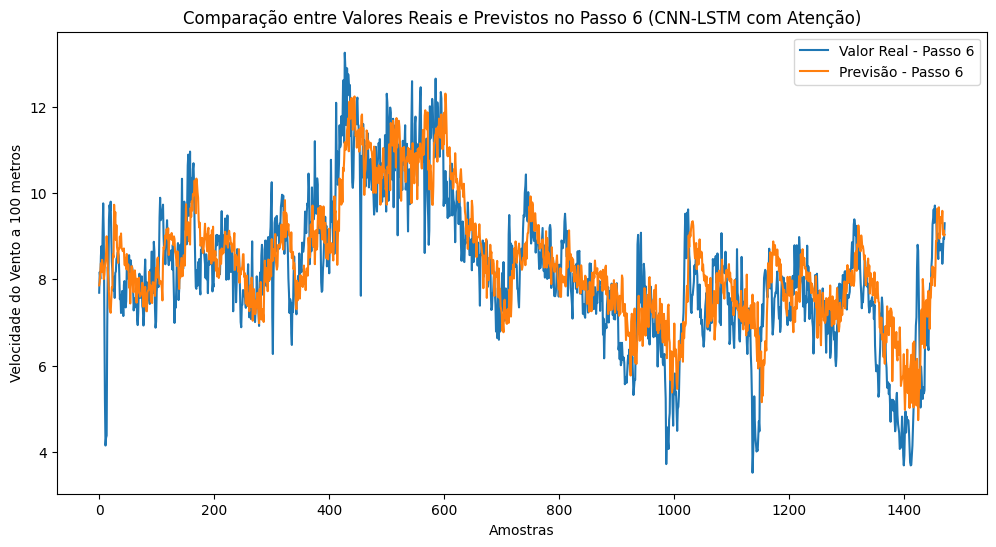

In [ ]:
# %%
# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)

# Inversão da padronização
ws100_min = scaler.data_min_[0]
ws100_max = scaler.data_max_[0]

y_pred_inv = y_pred * (ws100_max - ws100_min) + ws100_min
y_test_inv = y_test * (ws100_max - ws100_min) + ws100_min

# Número de passos de previsão
num_target_steps = y_test.shape[1]

# Avaliação e plotagem para cada passo de previsão
for step in range(num_target_steps):
    # Extrair os valores reais e previstos para o passo atual
    y_test_step = y_test_inv[:, step, 0]
    y_pred_step = y_pred_inv[:, step, 0]
    
    # Métricas de desempenho para o passo atual
    mae = mean_absolute_error(y_test_step, y_pred_step)
    rmse = np.sqrt(mean_squared_error(y_test_step, y_pred_step))
    mape = np.mean(np.abs((y_test_step - y_pred_step) / y_test_step)) * 100
    
    print(f"Passo {step+1}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%\n")
    
    # Plotagem das previsões para o passo atual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_step, label=f'Valor Real - Passo {step+1}')
    plt.plot(y_pred_step, label=f'Previsão - Passo {step+1}')
    plt.legend()
    plt.title(f'Comparação entre Valores Reais e Previstos no Passo {step+1} (CNN-LSTM com Atenção)')
    plt.xlabel('Amostras')
    plt.ylabel('Velocidade do Vento a 100 metros')
    plt.show()
